In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, num2date, date2num
from dask.distributed import Client
import xarray as xr
import fenics as fe
import yaml
import time as time_py
import logging
import os
import importlib
import pdb
import scipy as sp

In [2]:
import letkf_forecasting.letkf_io as letkf_io
import letkf_forecasting.letkf_forecasting as lf
import letkf_forecasting.random_functions as rf
import letkf_forecasting.tmh_plot as tp
import letkf_forecasting.advection
import letkf_forecasting.optical_flow
import letkf_forecasting.assimilation as assimilation
import letkf_forecasting.assimilation_accessories as aa
import letkf_forecasting.analyse_results as ar

In [3]:
%matplotlib inline

In [51]:
year = 2014


# # for 4/15
# month = 4
# day = 15
# hour = 20
# minute = 15

# for 5/29
month = 5
day = 29
hour = 19 
minute = 30

# # for 4/26
# month = 4
# day = 26
# hour = 20
# minute = 0

time_str = f'{year:04}-{month:02}-{day:02} {hour:02}:{minute:02}:00'

In [52]:
truth = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
truth = truth['ci']
truth = letkf_io.add_crop_attributes(truth)
truth_full = truth.copy()
truth = ar.return_error_domain(truth)

In [53]:
truth = truth.load()

In [54]:
west_east_err = ar.down_sample_coord(truth.west_east, 1)                   
south_north_err = ar.down_sample_coord(truth.south_north, 1)               
truth = truth.sel(west_east=west_east_err,                              
                  south_north=south_north_err)

In [55]:
base_folder = '/a2/uaren/travis/'
optimization_folder = None
run = 'owp_opt'

In [56]:
full_day = letkf_io.return_day(year,
                               month,
                               day,
                               run,
                               base_folder,
                               optimization_folder)

In [57]:
full_day = full_day.sel(time=time_str)

In [58]:
full_day = letkf_io.add_crop_attributes(full_day)
full_day = full_day.load()
full_day_ed = ar.return_error_domain(full_day)

/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [59]:
fd_mean = ar.return_ens_mean(full_day)

In [60]:
fd_mean_30 = ar.return_horizon(fd_mean, 30)

In [61]:
fd_ed_mean = ar.return_ens_mean(full_day_ed)

In [62]:
fore30 = ar.return_horizon(fd_ed_mean, 30)

In [63]:
fore30 = fore30.sel(west_east=west_east_err,                              
                  south_north=south_north_err)

In [64]:
# full30 = ar.return_horizon(full_day_ed, 30)

In [65]:
wrf = letkf_io.return_day(year,
                          month,
                          day,
                          'wrf_no_div',
                          base_folder)
wrf = wrf.sel(time=time_str)

In [66]:
wrf = wrf.load()

/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [67]:
wrf = letkf_io.add_crop_attributes(wrf)
wrf_ed = ar.return_error_domain(wrf)

In [68]:
wrf_ed_mean = ar.return_ens_mean(wrf_ed)

In [69]:
wrf30 = ar.return_horizon(wrf_ed_mean, 30)

In [70]:
wrf30 = wrf30.sel(west_east=west_east_err,                              
                  south_north=south_north_err)

In [71]:
# wrf_full_30 = ar.return_horizon(wrf, 30)
# wrf_full_30 = wrf_full_30.sel(ensemble_number=0)

In [72]:
opt_flow = letkf_io.return_day(year,
                          month,
                          day,
                          'opt_flow',
                          base_folder)
opt_flow = opt_flow.sel(time=time_str)

In [73]:
opt_flow = opt_flow.load()

/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [74]:
opt_flow = letkf_io.add_crop_attributes(opt_flow)
opt_flow_ed = ar.return_error_domain(opt_flow)

In [75]:
opt_flow_ed_mean = ar.return_ens_mean(opt_flow_ed)

In [76]:
opt_flow_30 = ar.return_horizon(opt_flow_ed_mean, 30)

In [77]:
opt_flow_30 = opt_flow_30.sel(west_east=west_east_err,                              
                  south_north=south_north_err)

In [78]:
# opt_flow_full_30 = ar.return_horizon(opt_flow, 30)
# opt_flow_full_30 = opt_flow_full_30.sel(ensemble_number=0)

In [79]:
truth_full = truth_full.sel(south_north=wrf.south_north,
                            west_east=wrf.west_east)

In [80]:
from matplotlib import colors

In [81]:
def return_edges(x):
    dx = x[1] - x[0]
    x = x - dx/2
    x = np.append(x, [x[-1] + dx])
    return x

In [82]:
# CI = xr.open_dataset(
#     f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
# CI = CI['ci']
# CI = CI.load()

In [84]:
# west_east_err_full = ar.down_sample_coord(CI.west_east, 1)                   
# south_north_err_full = ar.down_sample_coord(CI.south_north, 1) 

# CI = CI.sel(west_east=west_east_err_full,                              
#                   south_north=south_north_err_full)

In [85]:
# x_ci = CI.west_east.values
# y_ci = CI.south_north.values
# x_ci = return_edges(x_ci)
# y_ci = return_edges(y_ci)
# x_center = x_ci.mean()
# y_center = y_ci.mean()
# x_ci -= x_center
# y_ci -= y_center

x_ed = fore30.west_east.values
y_ed = fore30.south_north.values
x_ed = return_edges(x_ed)
y_ed = return_edges(y_ed)
x_ed -= x_center
y_ed -= y_center       

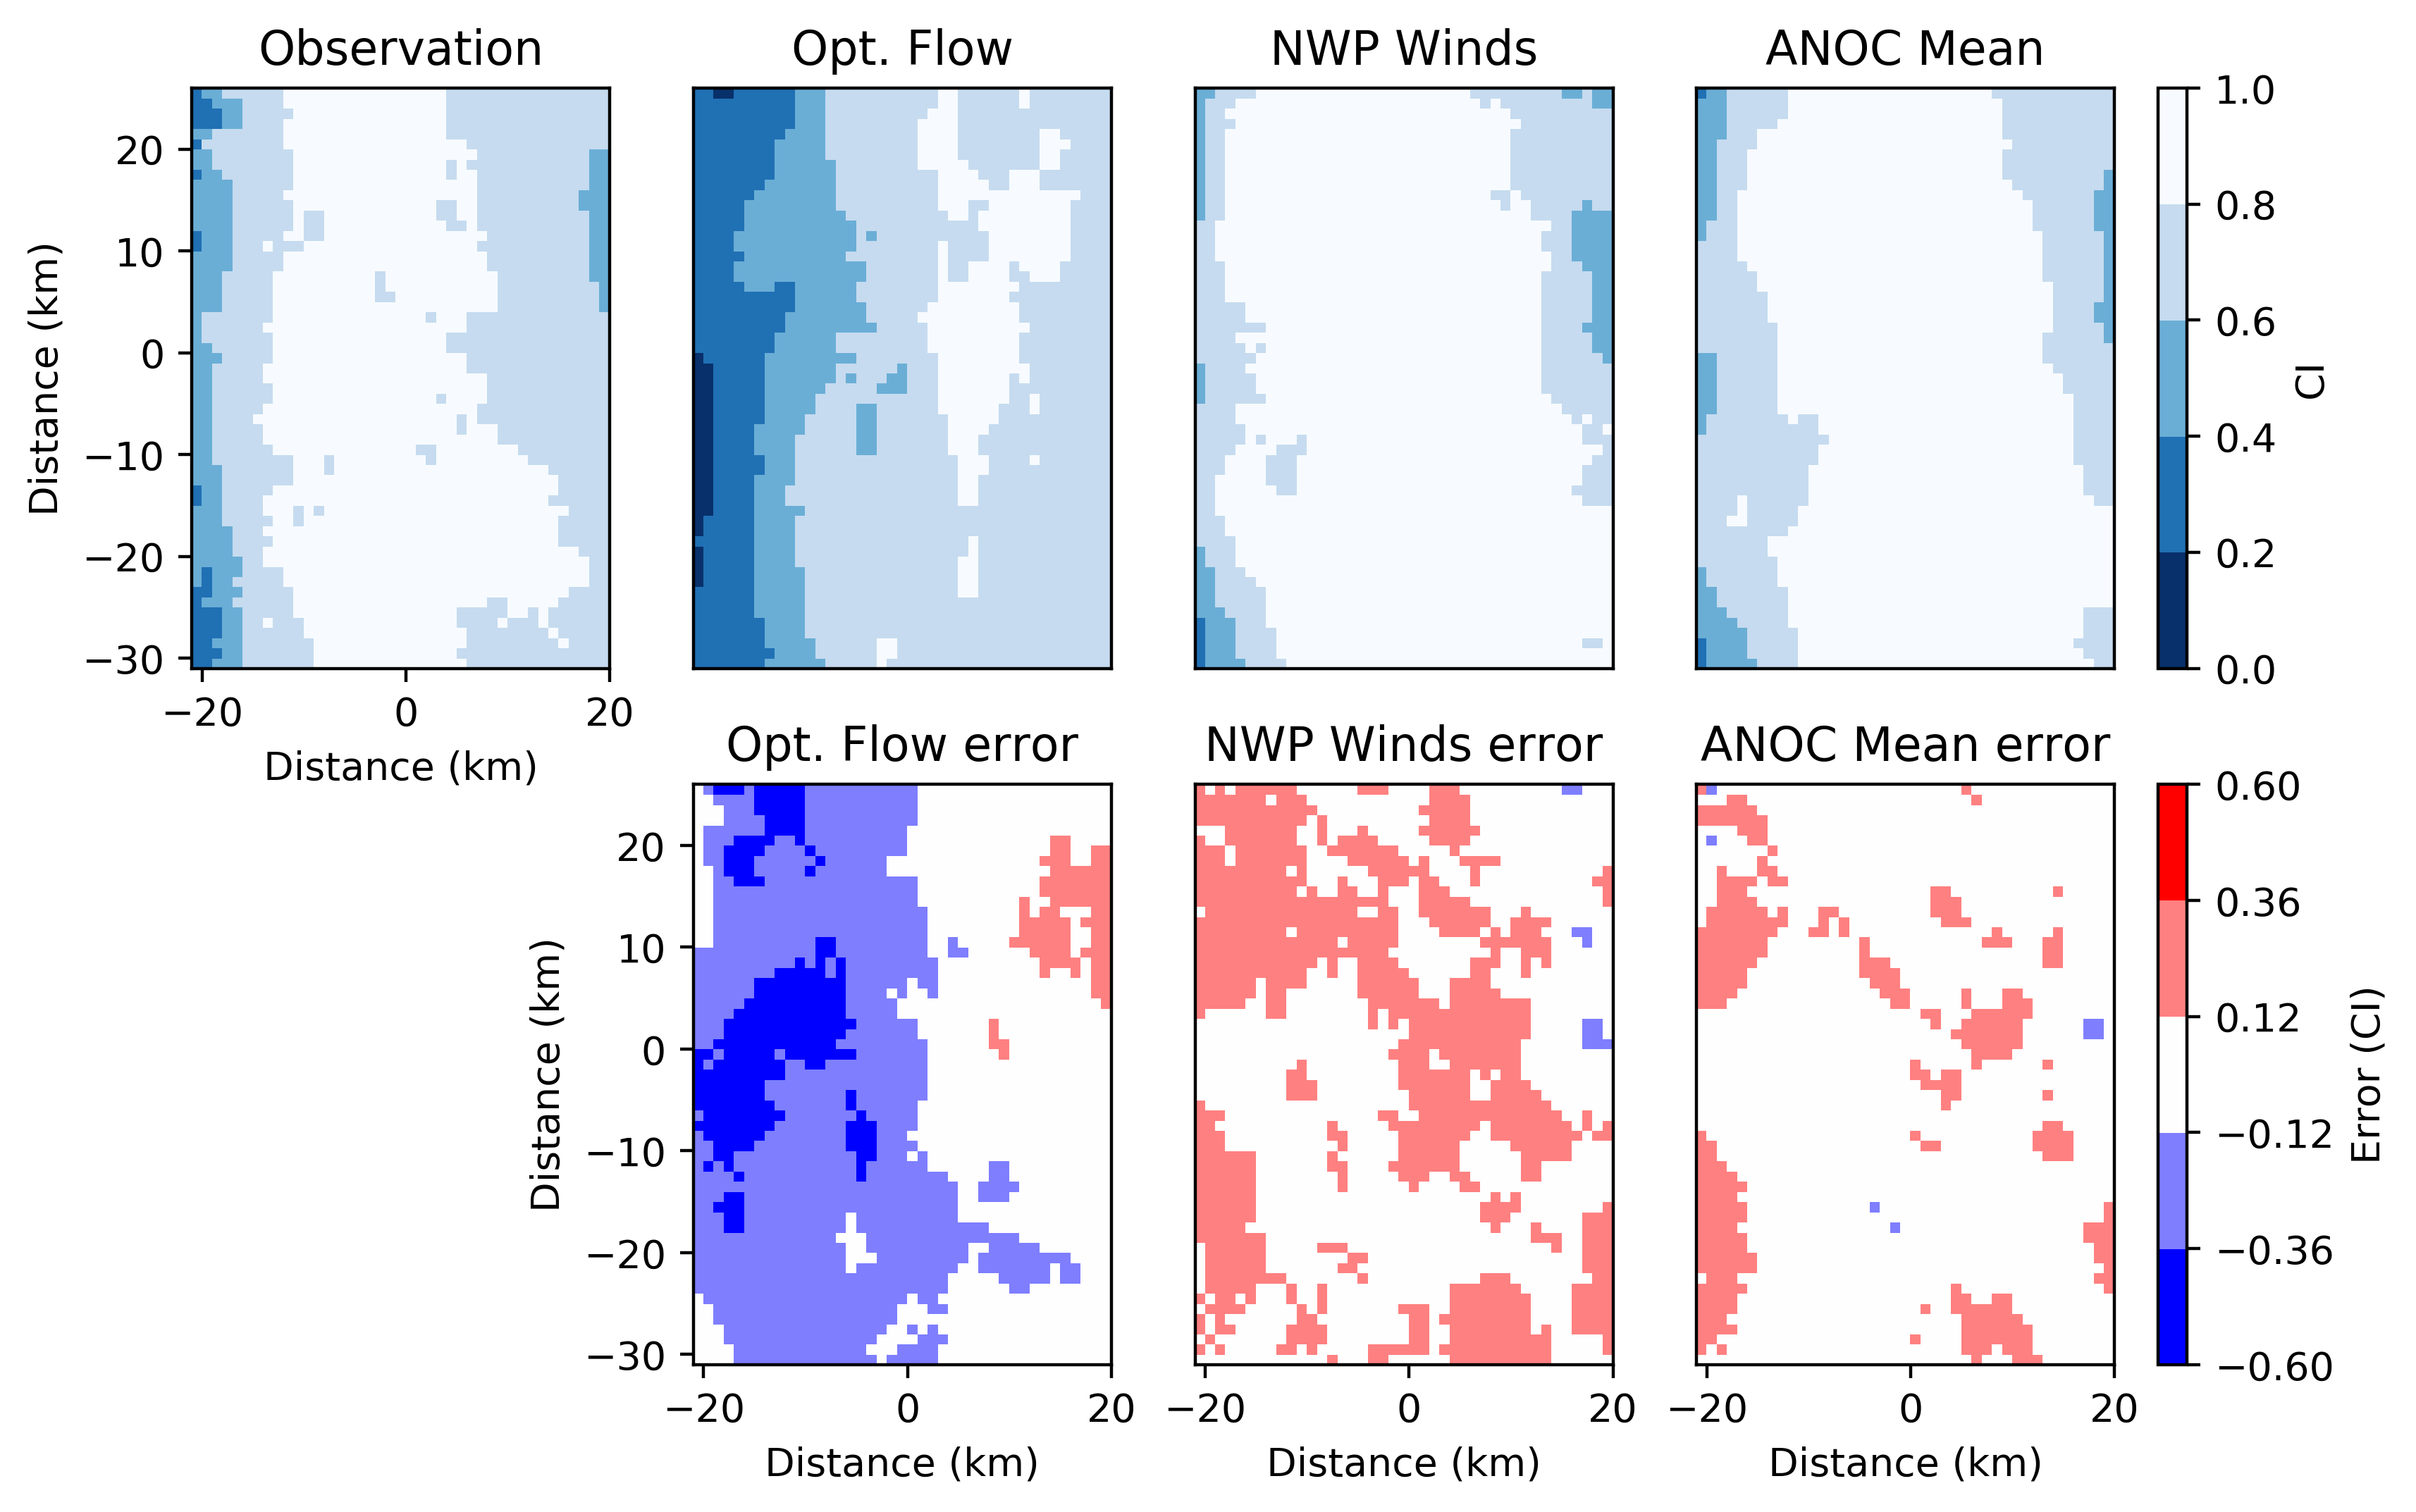

In [86]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 6
nc_er = 6
dpi = 400

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Observation')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('NWP Winds')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('NWP Winds error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('ANOC Mean')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('ANOC Mean error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')